## Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth **MSA**). **MSA** methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)

We will use the files of XML format (*curated_uniprot.fasta_*) with the information of hsp regions and the amino acid sequences.

In [49]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
import requests
from Bio.Blast import NCBIXML
from Bio import SeqIO, AlignIO
import ipywidgets as widgets
import scipy.stats
from collections import Counter

In [50]:
# Check the current directory
print('Current working directory:', os.getcwd())

Current working directory: /Users/alina/HMM


In [78]:
directory = "/Users/alina/HMM/"

### 1. Data Preparation

We have defined a function that parses an XML file into a pandas dataframe. This function can be utilized to include any additional columns from the BLAST results.

In [79]:
# Parse the XML file into a pandas dataframe
input_files = ['{}/curated_uniprot.fasta_75'.format(directory)]
dfs = []
max_query_length = 0

for input_file in input_files:
    with open(input_file) as f:
        blast_records = NCBIXML.parse(f)
        data = []

        # Iterate PSIBLAST rounds
        for blast_record in blast_records:
            query_id = blast_record.query

            # Get the length of the query sequence
            query_length = int(blast_record.query_letters)
            if query_length > max_query_length:
                max_query_length = query_length

            # Iterate alignments (here just one)
            for i, alignment in enumerate(blast_record.alignments):
                subject_id = alignment.title

                # Iterate pairwise alignments
                for hsp in alignment.hsps:
                    data.append((query_id.split(" ")[0], # it's not necessary to print the whole id
                                    subject_id.split(" ")[0], # the same as above
                                    query_length,
                                    hsp.align_length,
                                    hsp.query,
                                    hsp.match,
                                    hsp.sbjct,
                                    hsp.query_start,
                                    hsp.query_end,
                                    hsp.sbjct_start,
                                    hsp.sbjct_end,
                                    hsp.identities,
                                    hsp.positives,
                                    hsp.gaps,
                                    hsp.expect,
                                    hsp.score,
                                    ))

                    # Skip duplicated subjects
                    break

        dfs.append(pd.DataFrame(data, columns=["query_id", "subject_id", "query_len", "hsp_len", "query_seq",
                                               "match_seq", "subject_seq", "query_start", "query_end",
                                               "subject_start", "subject_end", "identity", "positive",
                                               "gaps", "eval", "bit_score"]))

In [80]:
# Print the resulting dataframe
df = dfs[0]
df

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR,391,387,LVIALLVVSLVVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVE...,LV LL V + +P L IW + L +L F ++GV VE...,LVFGLLAVPALAQDRPDLLIWADRTRTPPLTELATTFAEEFGVTVE...,5,390,14,397,141,220,4,7.015510e-82,695.0
8652,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR,391,405,FLVIALLVVSLVVL----AQPKLTIWCSEKQVDILQKLGEEFKAKY...,L++A++ +L VL L IW + + IL+ LG +FK ++...,LLIVAVMFGALGVLNVRAQDATLLIWADDTRAPILEALGAKFKEEF...,4,387,9,405,152,241,29,7.935620e-82,679.0
8653,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN,391,368,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,L +W + + + + F+ GV +EVQ V+F DI+ + A...,SLLVWTDANRAPVFESIAPAFEEATGVNIEVQIVDFGDIREQVQVA...,21,387,71,436,133,208,3,1.031540e-81,681.0
8654,tr|Q9X0T1|Q9X0T1_THEMA,tr|A0A101IFE6|A0A101IFE6_9CHLR,391,372,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,+ IW E++ +L +L +F A+YGVE+ V+ N I+ +F A...,SIRIWADEQRAPVLSELATDFLAEYGVELVVE--NISGIRDQFSVA...,21,391,63,424,151,214,11,1.137790e-81,687.0


### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

In [81]:
# Calculate the counts of subject IDs for the query ID and expand the dataframe with the new column
grouped = df.groupby('query_id')['subject_id'].nunique().reset_index(name='count')
df = pd.merge(df, grouped, on='query_id')
df.head()

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,sp|Q16620|NTRK2_HUMAN,tr|A0A2R9BM51|A0A2R9BM51_PANPA,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
1,sp|Q16620|NTRK2_HUMAN,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
2,sp|Q16620|NTRK2_HUMAN,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
3,sp|Q16620|NTRK2_HUMAN,tr|Q548C2|Q548C2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200


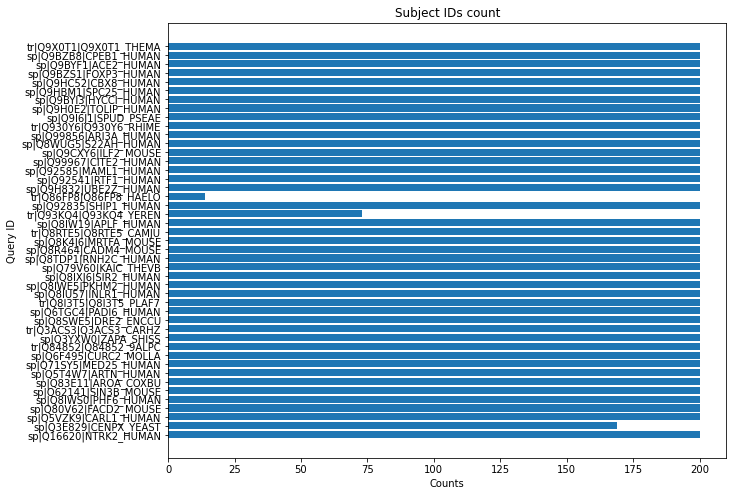

In [82]:
# Plot subject IDs count
figure(figsize=(10, 8))
plt.barh(df['query_id'], df['count'])
plt.xlabel('Counts')
plt.ylabel('Query ID')
plt.title('Subject IDs count')
plt.show()

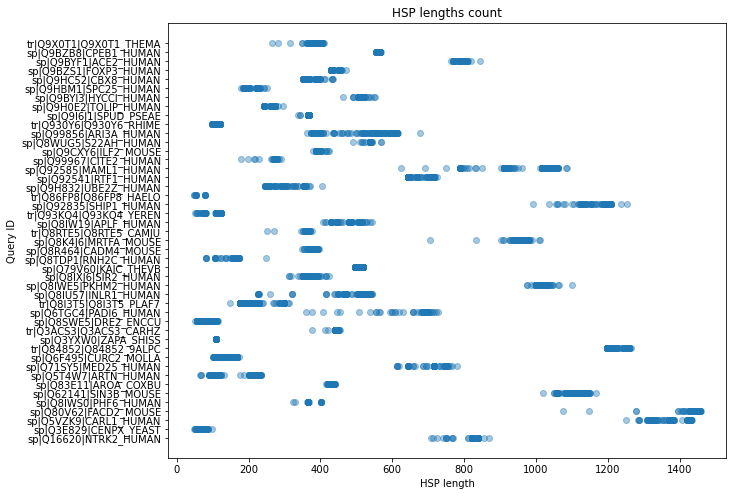

In [83]:
# Plot hsp length count
figure(figsize=(10, 8))
plt.scatter(df['hsp_len'], df['query_id'], alpha=0.4)
plt.xlabel('HSP length')
plt.ylabel('Query ID')
plt.title('HSP lengths count')
plt.show()

The scatterplot shows the positions of the sequences with the specific hsp length. The highest concentration represents the most frequent hsp length for a particular query ID.

Previously, we presented the overall proportion of unique subjects for all query IDs, but now we intend to conduct a separate analysis for each query ID. To begin, we will create a dropdown list of the query ID.

In [84]:
# Dropdown list of query IDs
output = widgets.Select(
    options=df["query_id"].unique(),
    rows=10,
    description='Query ID: ',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

Select(description='Query ID: ', layout=Layout(width='max-content'), options=('sp|Q16620|NTRK2_HUMAN', 'sp|Q3E…

Once the query ID list is generated, we need to select one of the IDs.

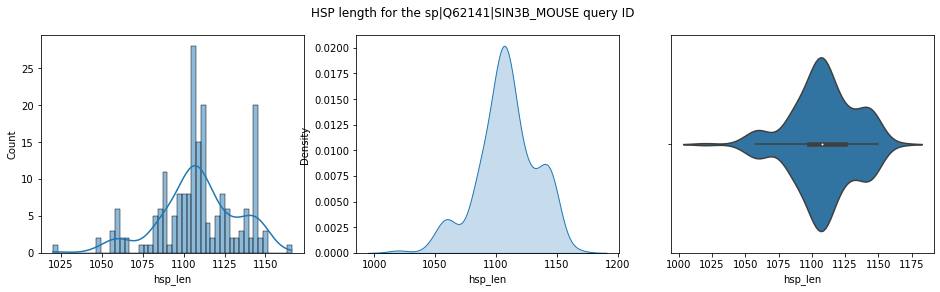

In [85]:
# Select query ID and filter dataframe
selected_id = output.value
selected = df[df["query_id"].isin([selected_id])]

# Create bar plot for HSP hits of selected query ID
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(selected['hsp_len'], kde = True, bins = 50, ax = ax1)
sns.kdeplot(selected['hsp_len'], shade = True, ax = ax2)
sns.violinplot(x = selected['hsp_len'], ax = ax3)
plt.suptitle(f'HSP length for the {selected_id} query ID')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

The `violinplot` provides the information about the interquartile range (thick gray line), median that is represented by a white dot and the rest of a distribution (thin gray line). The distribution's shape is presented on either side of the gray line through kernel density estimation. The wider sections of the violin plot represent a greater probability of the population taking on a specific value, while the narrower sections indicate a lower probability.

### 3. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

#### 1. MSA from the BLAST output

This code iterates through each row of the dataframe. If there is no gap, it maps the amino acid from the subject sequence to the corresponding position in the query sequence, starting from the beginning of the query sequence. The resulting mapped amino acids are then added to a new count. In the end we have a FASTA file with the subject IDs and the aligned sequences.

In [86]:
# 1. Build the MSA from the BLAST
out_files = ['{}/output_blast.fasta'.format(directory)]

for df, out_file in zip(dfs, out_files):
    with open(out_file, "w") as fout:
        for index, row in df.iterrows():
            max_row = df['query_seq'].str.len().max()
            mapped_seq = ["-"] * max_row
            c = 0
            if row["eval"] < 0.001:
                for l_q, l_s in zip(row['query_seq'], row['subject_seq']):
                    if l_q != " " and l_q != '-': # if the initial aa from query is empty or gapped
                        mapped_seq[row["query_start"] + c -1] = l_s if l_s != " " else "-" # assign aa to subject
                        c += 1
                fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))

After that we will check the quality of alignment taking into account the occupancy and the entropy.

In [87]:
# Improving the quality of MSA
seqs = []  # [[...], ...]
with open("{}/output_blast.fasta".format(directory)) as f:
    for record in AlignIO.read(f, "fasta"):
        seqs.append(list(record.seq))  # store sequence as a list of characters
seqs = np.array(seqs, dtype="str")
seqs

array([['M', 'S', 'S', ..., '-', '-', '-'],
       ['M', 'S', 'S', ..., '-', '-', '-'],
       ['M', 'S', 'S', ..., '-', '-', '-'],
       ...,
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-']], dtype='<U1')

In [93]:
aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

# Print max possible entropy
print(scipy.stats.entropy([1/20 for i in range(20)], base=20))

data = []
for i, column in enumerate(seqs.T):
    
    # count AA in column
    count = Counter(column)
    try:
        count.pop('-')
    except KeyError:
        pass
    #count.pop('-')
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
    
    # count non gap AA
    non_gap = np.count_nonzero(column != "-")
    
    occupancy = non_gap / column.size
    
    # AA probability in column (gap excluded)
    #probabilities = [count.get(k, 0.0) / column.size for k in aa] 
    if non_gap != 0:
        probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)  

    data.append([i, occupancy, entropy, count_sorted])
df_1 = pd.DataFrame(data, columns=['pos', 'occupancy', 'entropy', 'counts'])
df_1.head()

0.9999999999999999


,pos,occupancy,entropy,counts
0,0,0.617616,0.054771,"[(M, 5101), (L, 103), (I, 26), (V, 24), (F, 5)]"
1,1,0.642866,0.786934,"[(A, 1116), (S, 882), (V, 845), (E, 579), (R, ..."
2,2,0.656841,0.815592,"[(S, 986), (L, 916), (G, 669), (E, 616), (P, 5..."
3,3,0.665884,0.881946,"[(S, 899), (P, 647), (D, 593), (G, 536), (T, 4..."
4,4,0.682325,0.883490,"[(E, 757), (R, 749), (P, 608), (F, 469), (L, 4..."


For calculation of the `entropy` we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With `occupancy` we define the proportion of non-missing (non-gap) values in the column. 

In [99]:
df_1[(df_1['occupancy'] > 0.1) & (df_1['entropy'] < 0.5)]

,pos,occupancy,entropy,counts
0,0,0.617616,0.054771,"[(M, 5101), (L, 103), (I, 26), (V, 24), (F, 5)]"
1016,1016,0.133647,0.474418,"[(L, 400), (G, 321), (F, 199), (P, 198), (S, 1..."
1019,1019,0.117322,0.459167,"[(P, 398), (G, 200), (A, 200), (T, 193), (N, 5..."
1024,1024,0.117205,0.462447,"[(V, 333), (L, 262), (G, 200), (P, 199), (M, 3..."
1026,1026,0.117205,0.496135,"[(D, 399), (N, 201), (V, 200), (S, 138), (A, 5..."
1032,1032,0.117205,0.480896,"[(Q, 381), (F, 199), (K, 198), (P, 195), (R, 2..."
1037,1037,0.117087,0.465070,"[(E, 379), (D, 325), (W, 199), (G, 34), (N, 33..."
1044,1044,0.117087,0.458328,"[(R, 406), (K, 229), (D, 187), (G, 162), (E, 1..."
1056,1056,0.116735,0.280921,"[(D, 595), (S, 362), (A, 22), (P, 6), (E, 4), ..."
1061,1061,0.116970,0.489323,"[(R, 372), (E, 323), (L, 188), (T, 54), (K, 28..."


#### 2. MSA from the ClustalOmega

Initially, we will need to preprocess the dataframe into a suitable input format file for ClustalOmega. For this, we will use the Proteins API to retrieve the Uniprot accession codes.

In [90]:
# 2. Produce the unaligned sequence

out_file = '{}/output.fasta'.format(directory)
URL = "https://www.ebi.ac.uk/proteins/api/proteins" # The Proteins API

df = dfs[0]

chunk_size = 100
with open(out_file, 'w') as fout:  
    accessions = list(set([acc.split()[0].split("|")[1] for acc in df['subject_id']])) # for the initial file
    for i in range(0, len(accessions), chunk_size):
        r = requests.get(URL, params={'accession': ','.join(accessions[i: i + chunk_size])}, 
                      headers={'Accept': 'text/x-fasta'})
        fout.write(r.text + "\n")

To accommodate outputs larger than 4 MB and sequences exceeding 4000, which ClustalOmega can handle, we utilized Biopython to split the files based on specific conditions.

In [13]:
def batch_iterator(iterator, batch_size):

    batch = []
    for entry in iterator:
        batch.append(entry)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch

In [92]:
record_iter = SeqIO.parse(open("output.fasta"), "fasta")
for i, batch in enumerate(batch_iterator(record_iter, 1000)): # better 1000 to facilitate ClustalOmega work
    filename = "group_%i.fasta" % (i + 1)
    with open(filename, "w") as handle:
        count = SeqIO.write(batch, handle, "fasta")
    print("Wrote %i records to %s" % (count, filename))

Wrote 1000 records to group_1.fasta
Wrote 1000 records to group_2.fasta
Wrote 1000 records to group_3.fasta
Wrote 1000 records to group_4.fasta
Wrote 1000 records to group_5.fasta
Wrote 1000 records to group_6.fasta
Wrote 1000 records to group_7.fasta
Wrote 1000 records to group_8.fasta
Wrote 322 records to group_9.fasta


Next, we will be working with the newly generated files. These files will be uploaded to ClustalOmega, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can merge them and analyze the alignment using Jalview.

In [42]:
!cat *.fasta > clustal.fasta

In [64]:
# Improving the quality of MSA
seqs = []  # [[...], ...]
with open("{}/clustal_1.fasta".format(directory)) as f:
    for record in AlignIO.read(f, "fasta"):
        seqs.append(list(record.seq))  # store sequence as a list of characters
seqs = np.array(seqs, dtype="str")
seqs

array([['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ...,
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-'],
       ['-', '-', '-', ..., '-', '-', '-']], dtype='<U1')

In [65]:
aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

# Print max possible entropy
print(scipy.stats.entropy([1/20 for i in range(20)], base=20))

data = []
for i, column in enumerate(seqs.T):
    
    # count AA in column
    count = Counter(column)
    try:
        count.pop('-')
    except KeyError:
        pass
    #count.pop('-')
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
    
    # count non gap AA
    non_gap = np.count_nonzero(column != "-")
    
    occupancy = non_gap / column.size
    
    # AA probability in column (gap excluded)
    #probabilities = [count.get(k, 0.0) / column.size for k in aa] 
    if non_gap != 0:
        probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)  

    data.append([i, occupancy, entropy, count_sorted])
df_2 = pd.DataFrame(data, columns=['pos', 'occupancy', 'entropy', 'counts'])
df_2

0.9999999999999999


,pos,occupancy,entropy,counts
0,0,0.003,0.000000,"[(M, 3)]"
1,1,0.003,0.212474,"[(A, 2), (D, 1)]"
2,2,0.003,0.212474,"[(I, 2), (A, 1)]"
3,3,0.003,0.212474,"[(A, 2), (E, 1)]"
4,4,0.003,0.212474,"[(T, 2), (R, 1)]"
...,...,...,...,...
4353,4353,0.025,0.000000,"[(R, 25)]"
4354,4354,0.025,0.000000,"[(P, 25)]"
4355,4355,0.025,0.000000,"[(A, 25)]"
4356,4356,0.025,0.000000,"[(S, 25)]"


In [76]:
df_2[(df_2['occupancy'] > 0.2) & (df_2['entropy'] < 0.3)]

,pos,occupancy,entropy,counts
1473,1473,0.203,0.219887,"[(P, 173), (A, 14), (S, 7), (V, 2), (T, 2), (R..."
1486,1486,0.223,0.211375,"[(L, 188), (M, 22), (I, 6), (W, 2), (F, 1), (E..."
1515,1515,0.540,0.263932,"[(G, 445), (S, 26), (T, 23), (D, 21), (A, 11),..."
1963,1963,0.278,0.269147,"[(L, 220), (P, 24), (K, 21), (I, 4), (R, 3), (..."
2856,2856,0.220,0.266023,"[(V, 152), (I, 58), (M, 6), (T, 2), (L, 1), (G..."
